In [1]:
# Load libs
import numpy as np
import matplotlib.pyplot as plt
import os, glob

# Scipy
from scipy.stats import zscore

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import sklearn.metrics as skmetrics
from sklearn.metrics import roc_curve, auc

In [2]:
# Paths
from LoadPath import LoadPath
dataroot, coderoot = LoadPath('MAC')

# Pick up stuff from the codepath
os.chdir(coderoot)
import SteinmetzHelpers
import SteinmetzP_functions

In [3]:
# Set up matplotlib
%matplotlib inline
plt.style.use(coderoot + 'plotspecs.mplstyle')

### We would like to predict response type (left or right) using firing of neurons in visual and/or motor areas. We will take spike trains of the mouse with largest number of neurons in either areas, bin them and try several classic machine learning approaches for prediction. 

In [4]:
# Define groups of brain areas
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["MOp", "MOs"], # motor cortex
               ]

In [5]:
# Get all folders
fdir = glob.glob(os.path.join(dataroot, "*", ""))
# Find a mouse with most cells in the 
cells = np.zeros((len(brain_groups), len(fdir)))
for irec in range(len(fdir)):
    dat = SteinmetzP_functions.SteinmetzDataset(fdir[irec], 'react')
    for iarea in range(len(brain_groups)):
        cells[iarea,irec], gg = dat.countNeuronsinArea(brain_groups[iarea])

print(f"Recording #{np.argmax(cells[0,:])+1} has maximum of visual cortex neurons: {np.max(cells[0,:]):.0f}")
print(f"Recording #{np.argmax(cells[1,:])+1} has maximum of motor cortex neurons: {np.max(cells[1,:]):.0f}")

Recording #2 has maximum of visual cortex neurons: 533
Recording #11 has maximum of motor cortex neurons: 447


### We will take mouse with biggest number of motor cortex neurons

We will bin spike train in 50 ms bins

In [6]:
# Load the data
irec = np.argmax(cells[1,:]).item() # Get the number of a mouse with biggest number of neurons in motor cortex
binsize = 0.05 # 50 ms
EpochTime = 3.5
BeforeZero = 1.5
dataset = SteinmetzP_functions.LoadSteinmetzData(dataroot, sessionstoload=irec, eventtype='react', binsize=binsize,
                                                 dT=EpochTime, T0=BeforeZero)
data = dataset[0]

We will load the session number 11
Hench_2017-06-18 loaded successfully


In [7]:
# Create design matrix and responses
response = data.response
NT = data.spikes.shape[-1]

barea = np.zeros(len(data.brain_area))
barea[np.isin(data.brain_area, brain_groups[1])] = 1 # assign a number 1 to all neurons in motor cortex

idx_noreact = np.where(response==0)
idx_react = np.union1d(np.where(response<0), np.where(response>0))
outcomes = np.delete(response, idx_noreact)
outcomes[outcomes==-1] = 0

# Design matrix
spikes = data.spikes[:,idx_react,:] # Shape neurons*trials*bins
spikes = spikes[barea==1]
spikes = spikes[:,:,23:30] # Take [-300-0 ms from the reaction onset to predict]
spikes = np.transpose(spikes,(1,0,2)) # Shape trials * (bins*neurons)
spikes = np.reshape(spikes, (spikes.shape[0], spikes.shape[1]*spikes.shape[2]))

### Those are the structures that we will try to capture with classic ML algos

/Users/bryzgalovdm/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


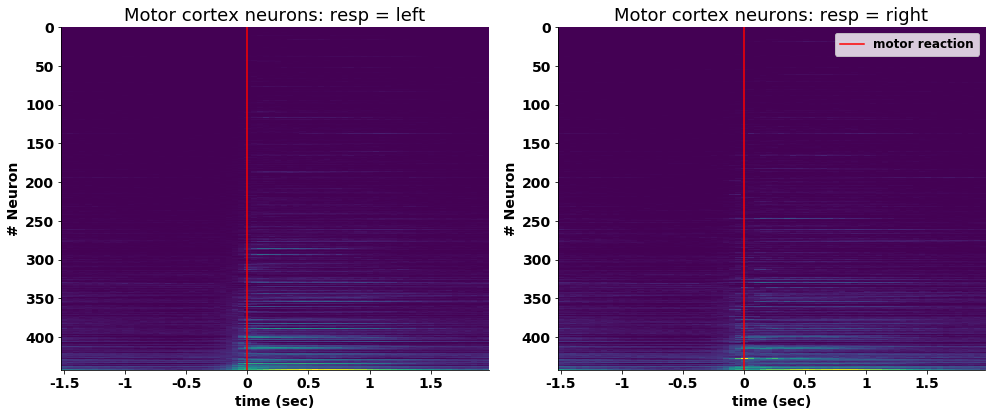

In [9]:
resp_type = [' neurons: resp = left', ' neurons: resp = right']

spk_resp_type = []
spikes_zcored = zscore(data.spikes, axis=2)
spk_resp_type.append(data.spikes[barea==1][:,response<0]) # Left
spk_resp_type.append(data.spikes[barea==1][:,response>0]) # Right

idx_sorted = np.argsort(spk_resp_type[0][:,:,23:30].mean(axis=(1,2)))
fig, axs = plt.subplots(1, 2, figsize=(14,6), gridspec_kw={'width_ratios': [1, 1]})
for iresp in range(len(spk_resp_type)):

    axs[iresp].imshow(spk_resp_type[iresp][idx_sorted].mean(axis=(1)), aspect='auto')
    axs[iresp].set_title('Motor cortex' + resp_type[iresp], fontsize=18)
    axs[iresp].axvline(30, color="red", label = 'response')

    axs[iresp].set(xlabel  = 'time (sec)', ylabel = '# Neuron');
    plt.legend(['motor reaction'], fontsize=12)
    axs[iresp].set_xticklabels(['', '-1.5', '-1', '-0.5', '0', '0.5', '1', '1.5', '2'])
    
fig.tight_layout()
plt.show()

### As you can see, on the first glance there is little difference between responses to the left and to the right

### We will leave 15% of trials for test sample. Next, we will apply logistic regression to predict motor response type. We will perform grid search over parameter space to determine the best ones

In [10]:
# Split X and y into test and train
spikes_train, spikes_test, outcomes_train, outcomes_test = train_test_split(spikes, outcomes, test_size=0.15)

In [11]:
# Find best parameters for logistic regression (penalty + C)
params_tosearch_logreg = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.005, 0.01, 0.5, 1, 10],
}

grid_logreg = GridSearchCV(estimator=LogisticRegression(solver='saga', max_iter=1000, n_jobs=-1),
                    param_grid=params_tosearch_logreg, scoring='f1',
                    cv = KFold(n_splits=5,shuffle = True))

grid_logreg.fit(spikes_train, outcomes_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.005, 0.01, 0.5, 1, 10],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

Log. regression: f1 for session 10 is 0.86
Log. regression: accuracy for session 10 is 0.86
              precision    recall  f1-score   support

         0.0       0.89      0.84      0.86        19
         1.0       0.84      0.89      0.86        18

    accuracy                           0.86        37
   macro avg       0.87      0.87      0.86        37
weighted avg       0.87      0.86      0.86        37



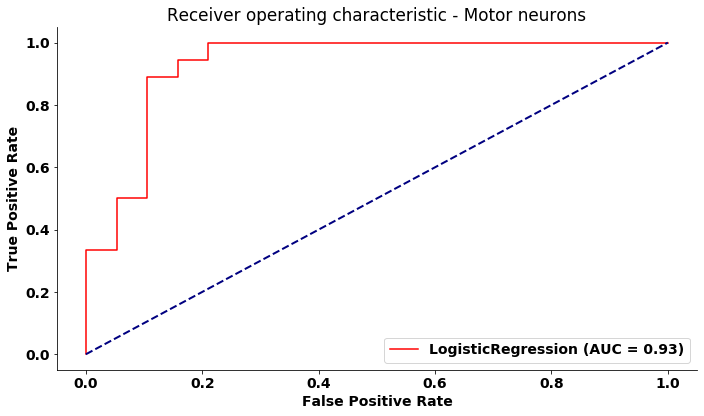

In [13]:
outcomes_pred_logreg = grid_logreg.best_estimator_.predict(spikes_test)
f1_logreg = skmetrics.f1_score(outcomes_test, outcomes_pred_logreg)
accuracy_logreg = skmetrics.accuracy_score(outcomes_test, outcomes_pred_logreg)
print(f'Log. regression: f1 for session {irec} is {f1_logreg:.2f}')
print(f'Log. regression: accuracy for session {irec} is {accuracy_logreg:.2f}')
print(skmetrics.classification_report(outcomes_test, outcomes_pred_logreg))

# ROC curve
fig, ax = plt.subplots(figsize=(10,6))
svc_disp = skmetrics.plot_roc_curve(grid_logreg.best_estimator_, spikes_test, outcomes_test, ax=ax, color='r')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_title('Receiver operating characteristic - Motor neurons')
plt.show()

### We can see that prediction is almost ideal with such simple linear algo as logistic regression. Let's have a look at how accurate the model is on other data splits

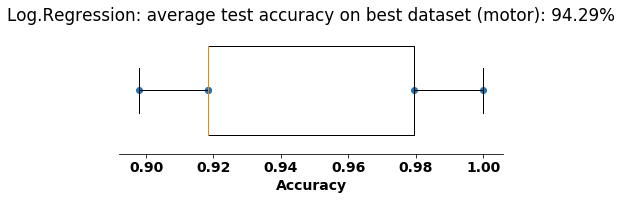

In [14]:
# Plot
accuracies_logreg = cross_val_score(grid_logreg.best_estimator_, spikes, y=outcomes, cv = KFold(n_splits=5,shuffle = True))

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies_logreg, vert=False, widths=.7)
ax.scatter(accuracies_logreg, np.ones(5))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Log.Regression: average test accuracy on best dataset (motor): {accuracies_logreg.mean():.2%}"
)
ax.spines["left"].set_visible(False)

### Very good! Let's see whether we can improve prediction by using SVM predictor

In [15]:
# %% Find best parameters for SVM (C + Kernel type)
params_tosearch_svm = {
    'C': [0.001, 0.005, 0.01, 0.5, 1, 2, 5, 10],
    'kernel': ['linear', 'poly', 'rbf'],
}

grid_svm = GridSearchCV(estimator=SVC(), param_grid=params_tosearch_svm, scoring='f1',
                    cv = KFold(n_splits=5,shuffle = True))

grid_svm.fit(spikes_train, outcomes_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.005, 0.01, 0.5, 1, 2, 5, 10],
                         'kernel': ['linear', 'poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

SVM: f1 for session 10 is 0.89
SVM: accuracy for session 10 is 0.89
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89        19
         1.0       0.89      0.89      0.89        18

    accuracy                           0.89        37
   macro avg       0.89      0.89      0.89        37
weighted avg       0.89      0.89      0.89        37



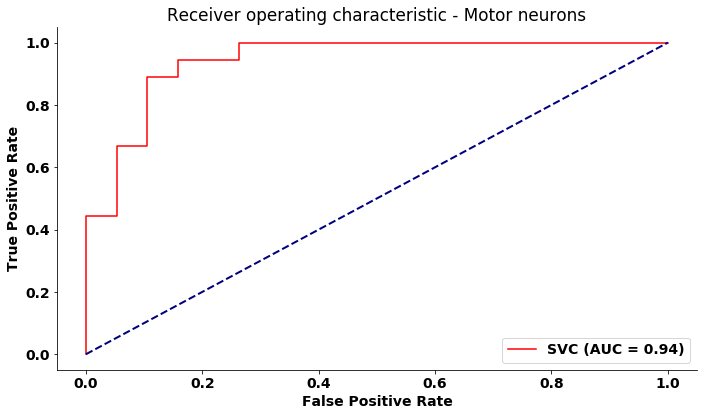

In [16]:
outcomes_pred_svm = grid_svm.best_estimator_.predict(spikes_test)
f1_svm = skmetrics.f1_score(outcomes_test, outcomes_pred_svm)
accuracy_svm = skmetrics.accuracy_score(outcomes_test, outcomes_pred_svm)
print(f'SVM: f1 for session {irec} is {f1_svm:.2f}')
print(f'SVM: accuracy for session {irec} is {accuracy_svm:.2f}')
print(skmetrics.classification_report(outcomes_test, outcomes_pred_svm))

# ROC curve
fig, ax = plt.subplots(figsize=(10,6))
svc_disp = skmetrics.plot_roc_curve(grid_svm.best_estimator_, spikes_test, outcomes_test, ax=ax, color='r')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_title('Receiver operating characteristic - Motor neurons')
plt.show()

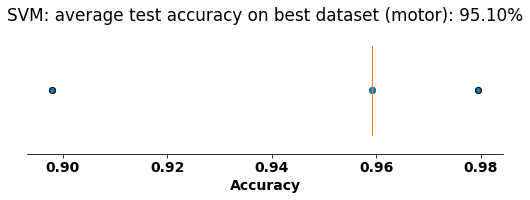

In [17]:
# Plot
accuracies_svm = cross_val_score(grid_svm.best_estimator_, spikes, y=outcomes, cv = KFold(n_splits=5,shuffle = True))

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies_svm, vert=False, widths=.7)
ax.scatter(accuracies_svm, np.ones(5))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"SVM: average test accuracy on best dataset (motor): {accuracies_svm.mean():.2%}"
)
ax.spines["left"].set_visible(False)

### Great! We gained 1% of accuracy. We will also try random forest classifier

SVM: f1 for session 10 is 0.89
SVM: accuracy for session 10 is 0.89
              precision    recall  f1-score   support

         0.0       0.94      0.84      0.89        19
         1.0       0.85      0.94      0.89        18

    accuracy                           0.89        37
   macro avg       0.90      0.89      0.89        37
weighted avg       0.90      0.89      0.89        37



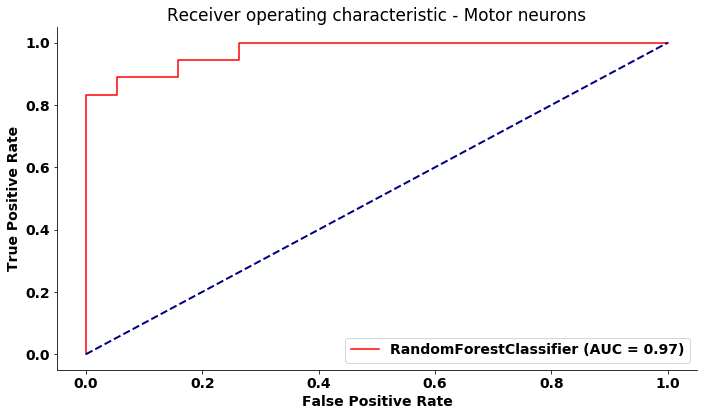

In [18]:
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=2, n_jobs=-2)
rf_model.fit(spikes_train, outcomes_train)

outcomes_pred_rf = rf_model.predict(spikes_test)
f1_rf = skmetrics.f1_score(outcomes_test, outcomes_pred_rf)
accuracy_rf = skmetrics.accuracy_score(outcomes_test, outcomes_pred_rf)
print(f'SVM: f1 for session {irec} is {f1_rf:.2f}')
print(f'SVM: accuracy for session {irec} is {accuracy_rf:.2f}')
print(skmetrics.classification_report(outcomes_test, outcomes_pred_rf))

# ROC curve
fig, ax = plt.subplots(figsize=(10,6))
svc_disp = skmetrics.plot_roc_curve(rf_model, spikes_test, outcomes_test, ax=ax, color='r')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_title('Receiver operating characteristic - Motor neurons')
plt.show()

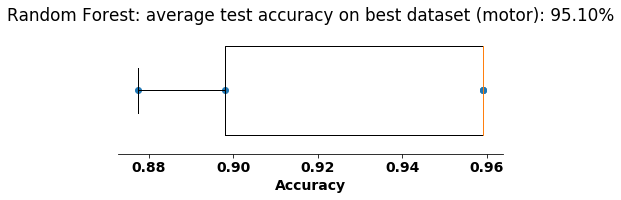

In [19]:
# Plot
accuracies_rf = cross_val_score(rf_model, spikes, y=outcomes, cv = KFold(n_splits=5,shuffle = True))

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies_rf, vert=False, widths=.7)
ax.scatter(accuracies_rf, np.ones(5))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Random Forest: average test accuracy on best dataset (motor): {accuracies_svm.mean():.2%}"
)
ax.spines["left"].set_visible(False)

# TODO:

### * Sliding window
### * Leave neurons out